Project#1
====
In this project, we will predict the toxicity of compounds using a neural network model (Mayr, Andreas, et al. "DeepTox: toxicity prediction using deep learning." Frontiers in Environmental Science 3 (2016): 80.). 

The given datasets are 'nr-ar.smiles' and 'nr-er.smiles' file. 

Each file contains 'smiles string of compound', 'array data', and 'activity value' (toxicity) at each raw. 

Activity value is marked as 0 when a compound is non-toxic, and 1 vice versa. 

We will use RDKit and Keras (tensorflow backend) package to build a prediction model. 

RDKit is the most widely used python package for handling chemical compounds. 

Keras is one of famous packages for the neural network.

A pseudo code (project1_pseudo_cod.py) is also provided (you can use this code or make your own code from scratch)

1) you need to build a neural network model for predicting the toxicity of compounds.

2) Train your model using the training dataset (and optimize your model using validation set).

3) Report the ROC-AUC score of the test dataset using the trained model.

4) Use google colab (or whatever you want)

5) Upload  jupyter notebook (".ipynb" file) or link to your google colab code 

Due date: Sep/22/23:59

In [3]:
# install rdkit library on colab environment
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

# %matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2019-09-23 02:37:04--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75257002 (72M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  71.77M   206MB/s    in 0.3s    

2019-09-23 02:37:10 (206 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [75257002/75257002]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==0.24.0=py37_0
    - bzip2==1.0.8=h7b6447c_0
    - ca-certificates==2019.5.15=0
    - certifi==2019.6.16=py37_0
    - cffi==1.12.3=py37h2e261b9_0
    - chardet==3.0.4=py37_1
    - conda-packag

In [4]:
#import basic python packages
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase

import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.backend import one_hot
from keras.layers import Activation, Dense, Dropout, Input
from keras.utils import np_utils

Using TensorFlow backend.


In [6]:
# load data from files
from google.colab import files
data_AR = files.upload() # select 'nr-ar.smiles' file and upload it
data_ER = files.upload() # select 'nr-er.smiels' file and upload it

# save the uploaded data as Pandas dataframe
import io
df_AR = pd.read_csv(io.BytesIO(data_AR['nr-ar.smiles']), sep = '\t', names = ['smiles', 'array', 'activity'])
df_ER = pd.read_csv(io.BytesIO(data_ER['nr-er.smiles']), sep = '\t', names = ['smiles', 'array', 'activity'])

smi_AR = df_AR['smiles']
smi_ER = df_ER['smiles']
activity_AR = df_AR['activity']
activity_ER = df_ER['activity']

Saving nr-ar.smiles to nr-ar.smiles


Saving nr-er.smiles to nr-er.smiles


In [7]:
from rdkit.Chem import AllChem

# data preprocessing; convert SMILES string to 2048 bit Fingerprint
def preprocessing(smi, activity):
  ###################
  ecfp = []
  target = []
  for ii in range(smi.shape[0]):
    s = smi[ii]
    m = Chem.MolFromSmiles(s)
    try:
      ecfp_bits = AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=2048).ToBitString()
      ecfp_np = np.array(list(map(int, str(ecfp_bits))))
      ecfp.append(ecfp_np)
      target.append(activity[ii])
    except:
      print("exclude "+s)

  target = np.array(target).reshape(-1)
  target = np.eye(2)[target]
  ###################
  return np.array(ecfp), np.array(target)

data_X_AR, data_Y_AR = preprocessing(smi_AR, activity_AR)
data_X_ER, data_Y_ER = preprocessing(smi_ER, activity_ER)

# check the shape of the raw data
print(data_X_AR.shape)
print(data_Y_AR.shape)
print(data_X_ER.shape)
print(data_Y_ER.shape)

exclude [NH4+].[NH4+].F[Si--](F)(F)(F)(F)F
exclude [Cl-][Pt]1([Cl-])NCCN1
exclude [NH4+].[NH4+].[Cl-][Pt++]([Cl-])([Cl-])[Cl-]
exclude [Na+].[Na+].F[Si--](F)(F)(F)(F)F
exclude O.O.O.O.O=C1O[Mg]2(OC(=O)C3=CC=CC=C3O2)OC4=CC=CC=C14
exclude [Cl-][Pt]1([Cl-])NCCN1
exclude [NH4+].[NH4+].[Cl-][Pt++]([Cl-])([Cl-])[Cl-]
exclude [Na+].[Na+].F[Si--](F)(F)(F)(F)F
exclude O.O.O.O.O=C1O[Mg]2(OC(=O)C3=CC=CC=C3O2)OC4=CC=CC=C14
(9357, 2048)
(9357, 2)
(7693, 2048)
(7693, 2)


In [0]:
!pip install imblearn

In [17]:
# split the training, validation and test dataset. train:validation:test=8:1:1
from sklearn.model_selection import train_test_split
#split training and test dataset from raw dataset
###################
X_train_AR, X_test_AR, Y_train_AR, Y_test_AR = train_test_split(data_X_AR, data_Y_AR, test_size=0.2, random_state=1)
X_train_ER, X_test_ER, Y_train_ER, Y_test_ER = train_test_split(data_X_ER, data_Y_ER, test_size=0.2, random_state=1)
###################

#split training and validation dataset from training dataset
###################
X_train_AR, X_valid_AR, Y_train_AR, Y_valid_AR = train_test_split(X_train_AR, Y_train_AR, test_size=0.25, random_state=1)
X_train_ER, X_valid_ER, Y_train_ER, Y_valid_ER = train_test_split(X_train_ER, Y_train_ER, test_size=0.25, random_state=1)

# oversample training set to deal with class imbalance
'''
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

Y_train_AR_class = np.argmax(Y_train_AR,axis=1)
X_train_AR,Y_train_AR_class = ros.fit_sample(X_train_AR,Y_train_AR_class)
Y_train_AR_class = np.array(Y_train_AR_class).reshape(-1)
Y_train_AR = np.eye(2)[Y_train_AR_class]

Y_train_ER_class = np.argmax(Y_train_ER,axis=1)
X_train_ER,Y_train_ER_class = ros.fit_sample(X_train_ER,Y_train_ER_class)
Y_train_ER_class = np.array(Y_train_ER_class).reshape(-1)
Y_train_ER = np.eye(2)[Y_train_ER_class]
'''
###################

# check the shape of the splited data
print(X_train_AR.shape, Y_train_AR.shape)
print(X_valid_AR.shape, Y_valid_AR.shape)
print(X_test_AR.shape, Y_test_AR.shape)
print(X_train_ER.shape, Y_train_ER.shape)
print(X_valid_ER.shape, Y_valid_ER.shape)
print(X_test_ER.shape, Y_test_ER.shape)

(5613, 2048) (5613, 2)
(1872, 2048) (1872, 2)
(1872, 2048) (1872, 2)
(4615, 2048) (4615, 2)
(1539, 2048) (1539, 2)
(1539, 2048) (1539, 2)


In [24]:
# build a neural network model
# the activation function of hidden layer is relu, and output is softmax

###################
from keras.layers import BatchNormalization, Activation
from keras.regularizers import l2
reg = 1e-5

# Shared layers
inputs = Input(shape=(2048,))
x = Dense(256, kernel_regularizer=l2(reg))(inputs)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)

x = Dense(256, kernel_regularizer=l2(reg))(x)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)

x = Dense(256, kernel_regularizer=l2(reg))(x)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = Dropout(rate=0.1)(x)

x = Dense(256, kernel_regularizer=l2(reg))(x)
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = Dropout(rate=0.2)(x)

# AR-specific layers
y = Dense(256, kernel_regularizer=l2(reg))(x)
y = BatchNormalization(axis=-1)(y)
y = Activation('relu')(y)
y = Dropout(rate=0.5)(y)
predictions_AR = Dense(2, activation='softmax')(y)

# ER-specific layers
z = Dense(256, kernel_regularizer=l2(reg))(x)
z = BatchNormalization(axis=-1)(z)
z = Activation('relu')(z)
z = Dropout(rate=0.5)(z)
predictions_ER = Dense(2, activation='softmax')(z)

from keras.optimizers import adam
###################

# make a prediction model for AR
###################
model_AR = Model(inputs=inputs, outputs=predictions_AR)
model_AR.compile(optimizer=adam(lr=1e-5,decay=1e-5),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
###################
model_AR.summary() # print summary of AR model


# make a predictin model for ER
###################
model_ER = Model(inputs=inputs, outputs=predictions_ER)
model_ER.compile(optimizer=adam(lr=5e-5,decay=1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
###################
model_ER.summary()# print summary of ER model

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
activation_25 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
activation_26 (Activation)   (None, 256)               0   

In [25]:
# early stopping with validation dataset 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es_AR = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_AR = ModelCheckpoint('best_model_AR.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
es_ER = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_ER = ModelCheckpoint('best_model_ER.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# training the model using training and validation set
epochs = 50
# train AR-classification task
hist_AR = model_AR.fit(X_train_AR, Y_train_AR, validation_data=(X_valid_AR, Y_valid_AR), batch_size=32, epochs=epochs, verbose=0, callbacks=[es_AR, mc_AR])
# then train ER-classification task
hist_ER = model_ER.fit(X_train_ER, Y_train_ER, validation_data=(X_valid_ER, Y_valid_ER),batch_size=32, epochs=epochs, verbose=0, callbacks=[es_ER, mc_ER])


Epoch 00001: val_acc improved from -inf to 0.64476, saving model to best_model_AR.h5

Epoch 00002: val_acc improved from 0.64476 to 0.77885, saving model to best_model_AR.h5

Epoch 00003: val_acc improved from 0.77885 to 0.86538, saving model to best_model_AR.h5

Epoch 00004: val_acc improved from 0.86538 to 0.92682, saving model to best_model_AR.h5

Epoch 00005: val_acc improved from 0.92682 to 0.94818, saving model to best_model_AR.h5

Epoch 00006: val_acc improved from 0.94818 to 0.95673, saving model to best_model_AR.h5

Epoch 00007: val_acc improved from 0.95673 to 0.96688, saving model to best_model_AR.h5

Epoch 00008: val_acc improved from 0.96688 to 0.96955, saving model to best_model_AR.h5

Epoch 00009: val_acc improved from 0.96955 to 0.97115, saving model to best_model_AR.h5

Epoch 00010: val_acc improved from 0.97115 to 0.97276, saving model to best_model_AR.h5

Epoch 00011: val_acc improved from 0.97276 to 0.97543, saving model to best_model_AR.h5

Epoch 00012: val_acc im

Text(0.5, 1.0, 'ER acc')

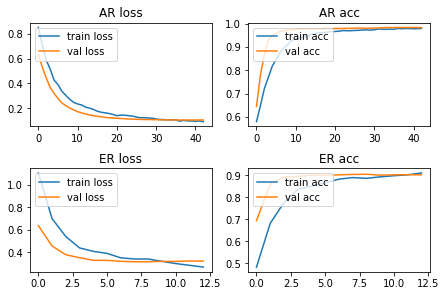

In [26]:
# plot the accuracy and loss value of each model.
###################
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, constrained_layout=True)
axs[0,0].plot(hist_AR.history['loss'], label='train loss')
axs[0,0].plot(hist_AR.history['val_loss'], label='val loss')
axs[0,0].legend(loc='upper left')
axs[0,0].set_title('AR loss')

axs[0,1].plot(hist_AR.history['acc'], label='train acc')
axs[0,1].plot(hist_AR.history['val_acc'], label='val acc')
axs[0,1].legend(loc='upper left')
axs[0,1].set_title('AR acc')

axs[1,0].plot(hist_ER.history['loss'], label='train loss')
axs[1,0].plot(hist_ER.history['val_loss'], label='val loss')
axs[1,0].legend(loc='upper left')
axs[1,0].set_title('ER loss')

axs[1,1].plot(hist_ER.history['acc'], label='train acc')
axs[1,1].plot(hist_ER.history['val_acc'], label='val acc')
axs[1,1].legend(loc='upper left')
axs[1,1].set_title('ER acc')
###################

1872/1872 [==============================] - 0s 122us/step
AR classification report
              precision    recall  f1-score   support

   not toxic       0.98      1.00      0.99      1796
       toxic       0.85      0.43      0.57        76

    accuracy                           0.97      1872
   macro avg       0.91      0.72      0.78      1872
weighted avg       0.97      0.97      0.97      1872

1539/1539 [==============================] - 0s 131us/step
ER classification report
              precision    recall  f1-score   support

   not toxic       0.90      0.97      0.93      1332
       toxic       0.61      0.29      0.39       207

    accuracy                           0.88      1539
   macro avg       0.76      0.63      0.66      1539
weighted avg       0.86      0.88      0.86      1539



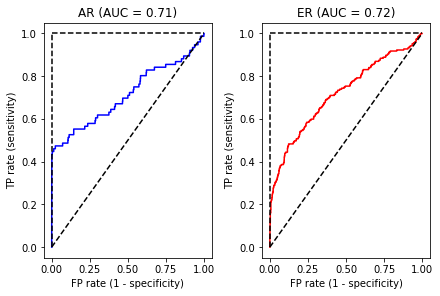

In [27]:
# evaluate the prediction model using test dataset.
from sklearn.metrics import classification_report, roc_curve, auc
# AUC of AR dataset
###################
Y_loss_AR, Y_acc_AR = model_AR.evaluate(X_test_AR, Y_test_AR)
Y_pred_AR = model_AR.predict(X_test_AR)

target_names = ['not toxic','toxic']
print("AR classification report")
print(classification_report(Y_test_AR[:,1]==1, Y_pred_AR[:,1]>0.5, target_names=target_names))

fpr, tpr, thresholds = roc_curve(Y_test_AR[:,1], Y_pred_AR[:,1])
roc_auc = auc(fpr, tpr)

fig, axs = plt.subplots(1,2, constrained_layout=True)
axs[0].set_title("AR (AUC = %0.2f)" % roc_auc)
axs[0].set_xlabel("FP rate (1 - specificity)")
axs[0].set_ylabel("TP rate (sensitivity)")
axs[0].plot(fpr, tpr, "b")
axs[0].plot([0, 0], [0, 1], "k--")
axs[0].plot([0, 1], [1, 1], "k--")
axs[0].plot([0, 1], [0, 1], "k--")
###################

# AUC of ER dataset
###################
Y_loss_ER, Y_acc_ER = model_ER.evaluate(X_test_ER, Y_test_ER)
Y_pred_ER = model_ER.predict(X_test_ER)

print("ER classification report")
print(classification_report(Y_test_ER[:,1]==1, Y_pred_ER[:,1]>0.5, target_names=target_names))

fpr, tpr, thresholds = roc_curve(Y_test_ER[:,1], Y_pred_ER[:,1])
roc_auc = auc(fpr, tpr)

axs[1].set_title("ER (AUC = %0.2f)" % roc_auc)
axs[1].set_xlabel("FP rate (1 - specificity)")
axs[1].set_ylabel("TP rate (sensitivity)")
axs[1].plot(fpr, tpr, "r")
axs[1].plot([0, 0], [0, 1], "k--")
axs[1].plot([0, 1], [1, 1], "k--")
axs[1].plot([0, 1], [0, 1], "k--")
###################